In [1]:
import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data
def data_preprocess(x_data):
    return x_data/255

In [35]:
#load data files
clean_test = 'data/cl/test.h5'
clean_val = 'data/cl/valid.h5'
bad_test = 'data/bd/bd_test.h5'
bad_val = 'data/bd/bd_valid.h5'

x_test_clean, y_test_clean = data_loader(clean_test)
x_va_clean, y_val_clean = data_loader(clean_val)
x_test_bd, y_test_bd = data_loader(bad_test)
x_val_bd, y_val_bd = data_loader(bad_val)

In [15]:
#load models
model_net = 'models/bd_net.h5'
model_weights = 'models/bd_weights.h5'

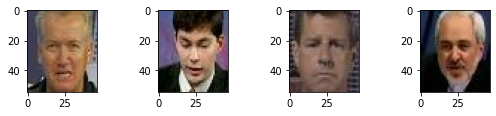

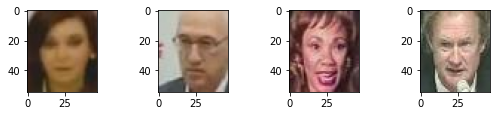

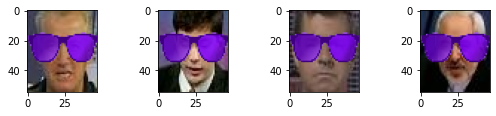

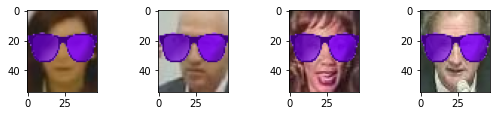

In [10]:
plt.figure(figsize=(9, 1.5))
for id in range(1, 5):
    plt.subplot(1, 4, id)
    plt.imshow(x_test_clean[id])

plt.figure(figsize=(9, 1.5))
for id in range(1, 5):
    plt.subplot(1, 4, id)
    plt.imshow(x_va_clean[id])

plt.figure(figsize=(9, 1.5))
for id in range(1, 5):
    plt.subplot(1, 4, id)
    plt.imshow(x_test_bd[id])

plt.figure(figsize=(9, 1.5))
for id in range(1, 5):
    plt.subplot(1, 4, id)
    plt.imshow(x_val_bd[id])    

In [50]:
bd_model = keras.models.load_model(model_net)
cl_label_p = np.argmax(bd_model.predict(x_va_clean), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, y_val_clean))
orign_acc = clean_accuracy
print('Clean Classification accuracy:', clean_accuracy*100)    
bd_label_p = np.argmax(bd_model.predict(x_val_bd), axis=1)
asr = np.mean(np.equal(bd_label_p, y_val_bd))*100
print('Attack Success Rate:', asr)

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


In [39]:
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Repair the model

In [55]:
X = [2, 4, 10]
for x in X:
    print('x = ',x)
    repaired_model = keras.models.clone_model(bd_model)
    repaired_model.set_weights(bd_model.get_weights())
    pruning_layer = repaired_model.get_layer('conv_3')
    layer_model = keras.Model(inputs=repaired_model.input, outputs=repaired_model.get_layer('conv_3').output)
    layer_pred = layer_model.predict(x_va_clean).sum(axis=(0, 1, 2))
    id_sort = np.argsort(layer_pred)

    for del_i in id_sort:
        if layer_pred[del_i] < 1e-5: continue
        weights = np.array(pruning_layer.get_weights()[0])
        bias = pruning_layer.get_weights()[1]
        weights[:, :, :, del_i] = np.zeros((3, 3, 40))
        pruning_layer.set_weights(list([weights, bias]))

        clean_pred = np.argmax(repaired_model.predict(x_va_clean), axis=1)
        acc =  np.mean(np.equal(clean_pred, y_val_clean))
        print(acc)
        if(orign_acc - acc) > x/100.0:
            print("diff:", orign_acc - acc)
            repaired_model.save('models/repaired_x{drop}.h5'.format(drop=x))
            break


x =  2
0.9864899974019226
0.9865765999826794
0.9864899974019226
0.9863167922404088
0.9863167922404088
0.9864899974019226
0.9865765999826794
0.9860569844981381
0.9856239715943536
0.9825928812678618
0.9822464709448342
0.9765307006148783
0.97592448254958
0.9579111457521434
diff: 0.028578851649779136
x =  4


/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


0.9864899974019226
0.9865765999826794
0.9864899974019226
0.9863167922404088
0.9863167922404088
0.9864899974019226
0.9865765999826794
0.9860569844981381
0.9856239715943536
0.9825928812678618
0.9822464709448342
0.9765307006148783
0.97592448254958
0.9579111457521434
0.9530614012297567
0.9486446696111545
0.9448341560578505
diff: 0.041655841344072075
x =  10
0.9864899974019226
0.9865765999826794
0.9864899974019226
0.9863167922404088
0.9863167922404088
0.9864899974019226
0.9865765999826794
0.9860569844981381
0.9856239715943536
0.9825928812678618
0.9822464709448342
0.9765307006148783
0.97592448254958
0.9579111457521434
0.9530614012297567
0.9486446696111545
0.9448341560578505
0.939724603793193
0.9229237031263532
0.894344851476574
0.8462804191564909
diff: 0.14020957824543168


Evaluate

Evaluate the model for x = 2%

In [59]:
repaired_model = keras.models.load_model('models/repaired_x2.h5')
clean_label_p = np.argmax(repaired_model.predict(x_test_clean), axis=1)
poisoned_label_p = np.argmax(repaired_model.predict(x_test_bd), axis=1)
class_accu_c = np.mean(np.equal(clean_label_p, y_test_clean))*100
class_accu_p = np.mean(np.equal(poisoned_label_p, y_test_bd))*100
print('Classification accuracy for clean inputs: {:.2f}%'.format(class_accu_c))
print('Attack Success Rate:: {:.2f}%'.format(class_accu_p))

Classification accuracy for clean inputs: 96.02%
Attack Success Rate:: 100.00%


Evaluate the model for x = 4%

In [60]:
repaired_model = keras.models.load_model('models/repaired_x4.h5')
clean_label_p = np.argmax(repaired_model.predict(x_test_clean), axis=1)
poisoned_label_p = np.argmax(repaired_model.predict(x_test_bd), axis=1)
class_accu_c = np.mean(np.equal(clean_label_p, y_test_clean))*100
class_accu_p = np.mean(np.equal(poisoned_label_p, y_test_bd))*100
print('Classification accuracy for clean inputs: {:.2f}%'.format(class_accu_c))
print('Attack Success Rate:: {:.2f}%'.format(class_accu_p))

Classification accuracy for clean inputs: 94.86%
Attack Success Rate:: 99.98%


Evaluate the model for x = 10%

In [61]:
repaired_model = keras.models.load_model('models/repaired_x10.h5')
clean_label_p = np.argmax(repaired_model.predict(x_test_clean), axis=1)
poisoned_label_p = np.argmax(repaired_model.predict(x_test_bd), axis=1)
class_accu_c = np.mean(np.equal(clean_label_p, y_test_clean))*100
class_accu_p = np.mean(np.equal(poisoned_label_p, y_test_bd))*100
print('Classification accuracy for clean inputs: {:.2f}%'.format(class_accu_c))
print('Attack Success Rate:: {:.2f}%'.format(class_accu_p))

Classification accuracy for clean inputs: 84.62%
Attack Success Rate:: 76.77%
